In [310]:
print("wewe")

wewe


In [311]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from langgraph.graph.message import add_messages

In [312]:
class State(TypedDict):

    messages:Annotated[list, add_messages]


graph_builder= StateGraph(State)

In [313]:
graph_builder

In [314]:
import os 
from dotenv import load_dotenv

In [315]:
load_dotenv()

True

In [316]:
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

In [345]:
llm = init_chat_model("openai:gpt-4o-2024-08-06")


In [346]:
def chatbot(state:State):

    #llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    
    # # Call the model with the current messages
    # response = model.invoke(state['messages'])
    
    # # The return value must be a dictionary with a key that matches the
    # # key in our State class ('messages'). This will update the state.
    # return {"messages": [response]}



    return {"messages":[llm.invoke(state["messages"])]}

In [347]:
graph_builder = StateGraph(State)
graph_builder.add_node("gptchatbot", chatbot)

graph_builder.add_edge(START,"gptchatbot")
graph_builder.add_edge("gptchatbot",END)


In [348]:
graph = graph_builder.compile()

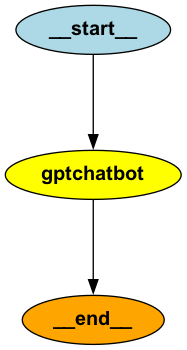

In [349]:
from IPython.display import Image, display

    # Get the graph object for visualization
graph_image = graph.get_graph()

    # Display the graph (e.g., in a Jupyter Notebook)
display(Image(graph_image.draw_png()))

In [350]:
graph_image.draw_png("my_langgraph.png")

In [351]:
graph.invoke({"messages":"hi haha"})

{'messages': [HumanMessage(content='hi haha', additional_kwargs={}, response_metadata={}, id='68e3c90a-5545-4142-b538-1a9a0b0b0282'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqkQbf9AhC6azb0vZIf5hbW2kM3HP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c94953c1-ca63-4426-9a79-3497116b83d5-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [352]:
for event in graph.stream({"messages":"hi what re what doings ??"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello! It seems like your message got a bit jumbled. Could you clarify or let me know what you'd like to discuss? I'm here to help with any questions or topics you're interested in.


# with tools


In [353]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_result = 2)
tool.invoke("What is this")

{'query': 'What is this',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://play.google.com/store/apps/details?id=com.google.ar.lens&hl=en_US',
   'title': 'Google Lens - Apps on Google Play',
   'content': 'Google Lens lets you search what you see, get things done faster, and understand the world around you—using just your camera or a photo.',
   'score': 0.090582706,
   'raw_content': None},
  {'url': 'https://search.google/ways-to-search/lens/',
   'title': 'Lens - Google Search',
   'content': 'Lens *   AI Overviews *   Lens Search what you see with Lens Use your camera, an image, or a screenshot to search. *   AI Overviews *   Image 1Lens *   Image 2AR *   Image 3Voice Just open Lens in the Google app, hold the shutter button and ask whatever’s on your mind — the same way you’d point at something and ask your friend about it. With Google Lens in Chrome desktop, easily select, search and ask questions about anything you see on the web, all 

In [354]:
def multiply(a:int,b:int) -> int:

    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int
    """

    return a * b

In [355]:
tools = [tool,multiply]

In [356]:
llm_with_tool = llm.bind_tools(tools)

In [357]:
llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x11d018c50>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x11d01acd0>, root_client=<openai.OpenAI object at 0x11d6698d0>, root_async_client=<openai.AsyncOpenAI object at 0x11d66a6d0>, model_name='gpt-4o-2024-08-06', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, '

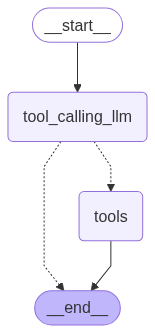

In [358]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


def tool_calling_llm(state:State):

    return {"messages":[llm_with_tool.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [359]:
response = graph.invoke({"messages":"What is the recent meta news?"})

In [360]:
response['messages'][-1].content

'{"query": "recent Meta news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/metas-ai-power-move-eight-openai-researchers-join-the-team", "title": "Meta\'s AI Power Move: Eight OpenAI Researchers Join the Team - OpenTools", "score": 0.750937, "published_date": "Tue, 01 Jul 2025 00:21:32 GMT", "content": "In a bold and strategic move, Meta has recruited eight top-tier researchers from OpenAI, sparking industry-wide discussions about talent wars, compensation packages, and the future of AI development. The recent recruitment moves by Meta, involving the acquisition of eight researchers from OpenAI, underscore a significant talent shift within the AI industry. The hiring of eight researchers from OpenAI by Meta has not only sparked a public disagreement between the two companies but has also highlighted the critical importance of talent acquisition in the rapidly evolving AI sector. The future of AI talent acquisition is poised t

In [361]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent meta news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_qLcTLsJowVQyXHxIX3E0R8cu)
 Call ID: call_qLcTLsJowVQyXHxIX3E0R8cu
  Args:
    query: recent Meta news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent Meta news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/metas-ai-power-move-eight-openai-researchers-join-the-team", "title": "Meta's AI Power Move: Eight OpenAI Researchers Join the Team - OpenTools", "score": 0.750937, "published_date": "Tue, 01 Jul 2025 00:21:32 GMT", "content": "In a bold and strategic move, Meta has recruited eight top-tier researchers from OpenAI, sparking industry-wide discussions about talent wars, compensation packages, and the future of AI de

In [363]:
response = graph.invoke({"messages":"give me the recent microsoft news and then multiply 573874857139084 by 1893472036043"})

In [364]:
response['messages'][-1].content

'1086615994181027135512004612'

In [365]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me the recent microsoft news and then multiply 573874857139084 by 1893472036043
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_4PUnl5rXtfknaNM2Xd9k8mzq)
 Call ID: call_4PUnl5rXtfknaNM2Xd9k8mzq
  Args:
    query: Microsoft news
    time_range: month
    topic: news
  multiply (call_qOiOwK9E9WRKl8ku7zigCapB)
 Call ID: call_qOiOwK9E9WRKl8ku7zigCapB
  Args:
    a: 573874857139084
    b: 1893472036043
================================= Tool Message =================================
Name: tavily_search

{"query": "Microsoft news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsbytesapp.com/news/business/microsoft-fires-9-000-employees-across-multiple-teams/story", "title": "Microsoft fires 4% of its workforce: Who are affected? - NewsBytes", "score": 0.57408494, "published_date": "Wed, 02 Jul

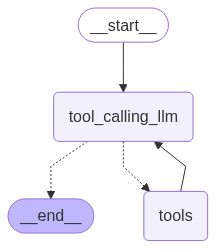

In [366]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


def tool_calling_llm(state:State):

    return {"messages":[llm_with_tool.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

builder.add_edge("tool_calling_llm",END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [368]:
response = graph.invoke({"messages":"give me the recent microsoft news and then multiply 573874857139084 by 1893472036043"})


response['messages'][-1].content

for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

give me the recent microsoft news and then multiply 573874857139084 by 1893472036043
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_KCqxMr9F4M5uCUyxSEELBcrL)
 Call ID: call_KCqxMr9F4M5uCUyxSEELBcrL
  Args:
    query: Microsoft recent news
    search_depth: basic
    topic: news
  multiply (call_FWbgAjxJTAiTlg12PSF7auUw)
 Call ID: call_FWbgAjxJTAiTlg12PSF7auUw
  Args:
    a: 573874857139084
    b: 1893472036043
================================= Tool Message =================================
Name: tavily_search

{"query": "Microsoft recent news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.globalvillagespace.com/microsoft-ends-25-year-journey-in-pakistan-social-media-reacts/", "title": "Microsoft Ends 25-Year Journey in Pakistan, Social Media Reacts - Global Village Space", "score": 0.65412235

In [371]:
response = graph.invoke({"messages":" hi how are you ?? my name is jordan"})


response['messages'][-1].content

for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

 hi how are you ?? my name is jordan
================================== Ai Message ==================================

Hello Jordan! I'm just a virtual assistant, so I don't have feelings, but I'm here to help you with any questions or tasks you might have. How can I assist you today?


In [372]:
response = graph.invoke({"messages":"hey what is my name"})


response['messages'][-1].content

for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

hey what is my name
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you tell me your name, I can address you accordingly!


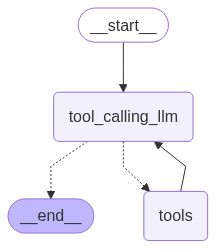

In [377]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state:State):

    return {"messages":[llm_with_tool.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools","tool_calling_llm")

builder.add_edge("tool_calling_llm",END)


graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
config={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi I am jamalath basha from ap ceeded area"}, config=config)


response['messages'][-1].content

for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

Hi I am jamalath basha from ap ceeded area
================================== Ai Message ==================================

Hello Jamalath Basha! How can I assist you today?


In [379]:
response = graph.invoke({"messages":"hey what is my name"}, config=config)


response['messages'][-1].content

for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

Hi I am jamalath basha from ap ceeded area
================================== Ai Message ==================================

Hello Jamalath Basha! How can I assist you today?
================================ Human Message =================================

hey what is my name
================================== Ai Message ==================================

Your name is Jamalath Basha. How can I assist you further?


# streaming

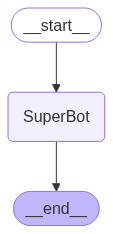

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def superbot(state:State):

    return {"messages":[llm_with_tool.invoke(state["messages"])]}


builder = StateGraph(State)
builder.add_node("SuperBot",superbot)


builder.add_edge(START,"SuperBot")
builder.add_edge("SuperBot",END)


graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


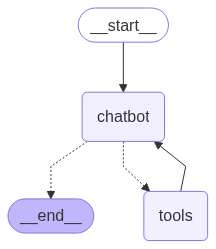

In [387]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [391]:

user_input = "I need some expert guidance for building some cool AI agents. Could you request assistance for me?"

config = {"configurable" : {"thread_id":"7"}}


events = graph.stream(
    {"messages" : user_input},
    config,
    stream_mode = 'values',
)

for event in events:
    if 'messages' in event:
        event["messages"][-1].pretty_print()



================================ Human Message =================================

I need some expert guidance for building some cool AI agents. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_mfWCTwims1VJNSJ68QJ7tr2l)
 Call ID: call_mfWCTwims1VJNSJ68QJ7tr2l
  Args:
    query: I need expert guidance on building AI agents, including techniques, tools, and best practices. Looking for detailed advice from professionals in the field.


In [393]:
human_feed = {"We, the experts are here to help!! We'd recommend you to check out Langgraph to build some cool agents."
              " It is a very good and reliable tool and simple to use."
              }

human_command = Command(resume={"data": human_feed})

events = graph.stream(human_command, config, stream_mode = 'values')

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_mfWCTwims1VJNSJ68QJ7tr2l)
 Call ID: call_mfWCTwims1VJNSJ68QJ7tr2l
  Args:
    query: I need expert guidance on building AI agents, including techniques, tools, and best practices. Looking for detailed advice from professionals in the field.
================================= Tool Message =================================
Name: human_assistance

{"We, the experts are here to help!! We'd recommend you to check out Langgraph to build some cool agents. It is a very good and reliable tool and simple to use."}
================================== Ai Message ==================================

Expert guidance is now available! The experts recommend checking out Langgraph, a reliable and user-friendly tool for building AI agents. It should provide you with the techniques, tools, and best practices you need. If you have any more questions, feel free to ask!
